<a href="https://colab.research.google.com/github/Kdavis2025/Automating-Compliance-AI-and-Machine-Learning-Approaches-to-Achieviing-CMMC-2.0-Certification/blob/main/Marketplaces_for_C3PAO_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Content-Based Recommendation ===
1. C3PAO_A (sim=0.995)
2. C3PAO_D (sim=0.988)
3. C3PAO_C (sim=0.950)
4. C3PAO_E (sim=0.894)
5. C3PAO_B (sim=0.793)


<ipython-input-1-b306a24f1ba5>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='C3PAO_ID', y='similarity', data=content_df, palette='Blues_d')


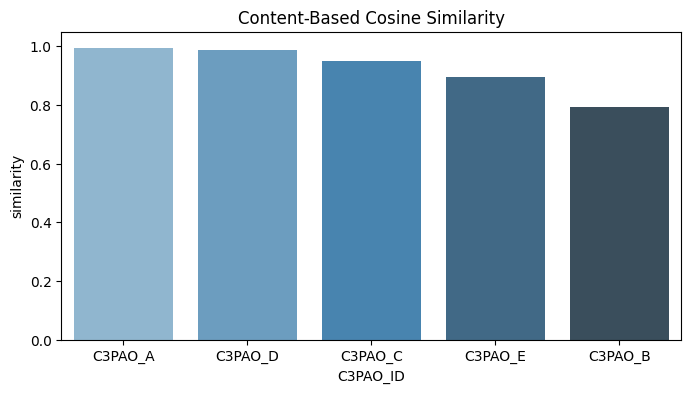


=== Collaborative Baseline RMSE ===
RMSE = 1.436


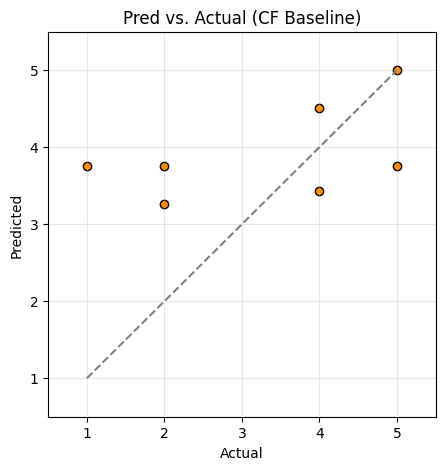


=== Hybrid Recommendation ===
1. C3PAO_A (hybrid=0.991)
2. C3PAO_C (hybrid=0.889)
3. C3PAO_D (hybrid=0.859)
4. C3PAO_E (hybrid=0.721)
5. C3PAO_B (hybrid=0.500)


<ipython-input-1-b306a24f1ba5>:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='C3PAO_ID', y='hybrid_score', data=hybrid_df, palette='viridis')


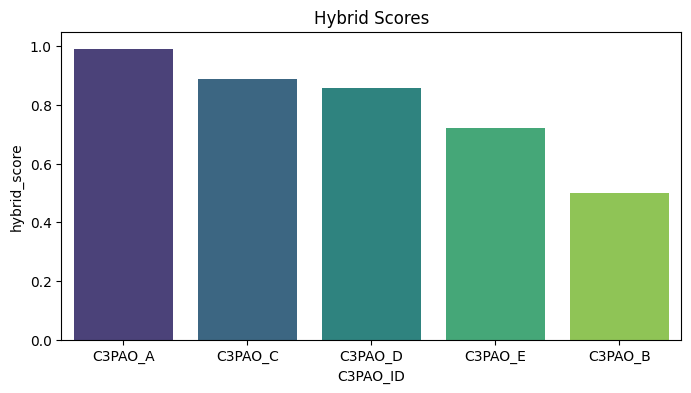


=== Simulated Cost Savings (1000 runs) ===
Avg naive fee: $49,800
Avg hybrid fee: $30,000
Avg savings:  $19,800


<ipython-input-1-b306a24f1ba5>:142: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(naive_costs, label='Naive', shade=True, color='orange')
<ipython-input-1-b306a24f1ba5>:143: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(hybrid_costs, label='Hybrid', shade=True, color='teal')
<ipython-input-1-b306a24f1ba5>:143: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(hybrid_costs, label='Hybrid', shade=True, color='teal')


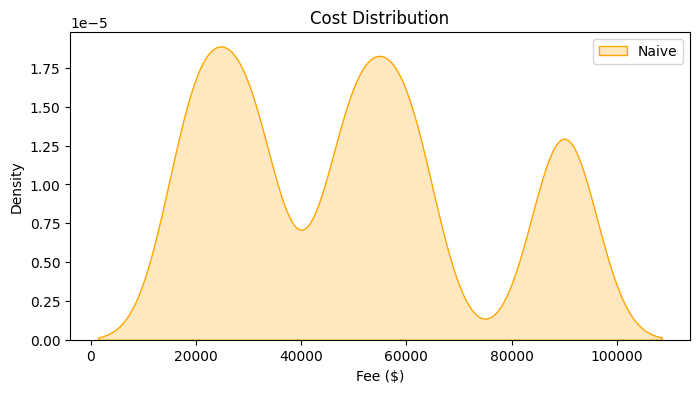

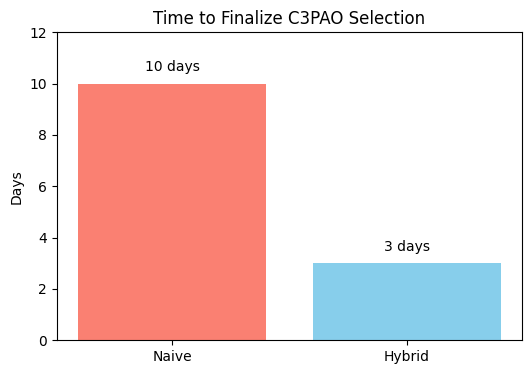

In [ ]:
# -----------------------
# Imports & Setup
# -----------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
import random
import seaborn as sns

np.random.seed(42)
random.seed(42)
%matplotlib inline

# -----------------------
# 1. Simulate C3PAO data
# -----------------------
c3paos = pd.DataFrame({
    'C3PAO_ID': ['C3PAO_A', 'C3PAO_B', 'C3PAO_C', 'C3PAO_D', 'C3PAO_E'],
    'cost':             [0.20,        0.80,       0.50,       0.10,       0.40],
    'location_factor':  [0.80,        0.40,       0.60,       0.90,       0.30],
    'rating':           [0.90,        0.60,       0.95,       0.70,       0.50]
})
c3paos.set_index('C3PAO_ID', inplace=True)

contractor_needs = np.array([0.25, 0.85, 0.80])  # desired cost, location, rating

# -----------------------
# 2. Content-Based Filtering
# -----------------------
features = c3paos[['cost','location_factor','rating']].values
sim_values = cosine_similarity(contractor_needs.reshape(1,-1), features).flatten()

content_df = pd.DataFrame({
    'C3PAO_ID': c3paos.index,
    'similarity': sim_values
}).sort_values('similarity', ascending=False).reset_index(drop=True)

print("=== Content-Based Recommendation ===")
for i,row in content_df.iterrows():
    print(f"{i+1}. {row['C3PAO_ID']} (sim={row['similarity']:.3f})")

plt.figure(figsize=(8,4))
sns.barplot(x='C3PAO_ID', y='similarity', data=content_df, palette='Blues_d')
plt.title("Content-Based Cosine Similarity"); plt.ylim(0,1.05)
plt.show()

# -----------------------
# 3. Collaborative Filtering (Basic Baseline)
# -----------------------
# Simulate user–item ratings (10 users, 5 items), ~30% missing
n_users = 10
user_ids = [f"Contractor_{i+1}" for i in range(n_users)]
item_ids = list(c3paos.index)
rating_records = []
for u in user_ids:
    for item in item_ids:
        if np.random.rand() < 0.3:
            continue
        rating_records.append({'user':u, 'item':item, 'rating': np.random.randint(1,6)})
ratings_df = pd.DataFrame(rating_records)

# Split train/test
train_rows,test_rows = [],[]
for _,row in ratings_df.iterrows():
    (test_rows if np.random.rand()<0.2 else train_rows).append(row)
train_df = pd.DataFrame(train_rows).reset_index(drop=True)
test_df  = pd.DataFrame(test_rows).reset_index(drop=True)

mu = train_df['rating'].mean()
user_mean = train_df.groupby('user')['rating'].mean()
b_u = user_mean - mu
item_mean = train_df.groupby('item')['rating'].mean()
b_i = item_mean - mu

def predict_rating(user, item):
    return min(max(mu + b_u.get(user,0.0) + b_i.get(item,0.0),1.0),5.0)

preds, actuals = [], []
for _,row in test_df.iterrows():
    p = predict_rating(row['user'], row['item'])
    preds.append(p)
    actuals.append(row['rating'])
rmse = sqrt(mean_squared_error(actuals,preds))
print(f"\n=== Collaborative Baseline RMSE ===\nRMSE = {rmse:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(actuals, preds, c='darkorange', edgecolor='k')
plt.plot([1,5],[1,5], linestyle='--', color='gray')
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title("Pred vs. Actual (CF Baseline)")
plt.xlim(0.5,5.5); plt.ylim(0.5,5.5); plt.grid(alpha=0.3)
plt.show()

# -----------------------
# 4. Hybrid Approach
# -----------------------
target_user = 'Contractor_1'
collab_scores = []
for c in c3paos.index:
    # predict rating 1..5 → normalize to 0..1
    pr = predict_rating(target_user, c)
    collab_scores.append((pr - 1.0)/4.0)

hybrid_df = content_df.copy()
hybrid_df['collab_norm'] = collab_scores
sim_arr = hybrid_df['similarity'].values
hybrid_df['content_norm'] = (sim_arr - sim_arr.min()) / (sim_arr.max() - sim_arr.min())
hybrid_df['hybrid_score'] = 0.5*hybrid_df['content_norm'] + 0.5*hybrid_df['collab_norm']
hybrid_df = hybrid_df.sort_values('hybrid_score', ascending=False).reset_index(drop=True)

print("\n=== Hybrid Recommendation ===")
for i,row in hybrid_df.iterrows():
    print(f"{i+1}. {row['C3PAO_ID']} (hybrid={row['hybrid_score']:.3f})")

plt.figure(figsize=(8,4))
sns.barplot(x='C3PAO_ID', y='hybrid_score', data=hybrid_df, palette='viridis')
plt.title("Hybrid Scores"); plt.ylim(0,1.05)
plt.show()

# -----------------------
# 5. Simulated Cost & Time Savings
# -----------------------
def norm_to_dollars(nc):
    return 100_000*nc + 10_000

n_sim = 1000
naive_costs, hybrid_costs = [], []
for _ in range(n_sim):
    naive_c = random.choice(c3paos.index)
    naive_costs.append(norm_to_dollars(c3paos.loc[naive_c,'cost']))
    best_h = hybrid_df.loc[0,'C3PAO_ID']
    hybrid_costs.append(norm_to_dollars(c3paos.loc[best_h,'cost']))

print("\n=== Simulated Cost Savings (1000 runs) ===")
print(f"Avg naive fee: ${np.mean(naive_costs):,.0f}")
print(f"Avg hybrid fee: ${np.mean(hybrid_costs):,.0f}")
print(f"Avg savings:  ${np.mean(naive_costs)-np.mean(hybrid_costs):,.0f}")

plt.figure(figsize=(8,4))
sns.kdeplot(naive_costs, label='Naive', shade=True, color='orange')
sns.kdeplot(hybrid_costs, label='Hybrid', shade=True, color='teal')
plt.xlabel("Fee ($)"); plt.title("Cost Distribution"); plt.legend()
plt.show()

# Time savings: naive=10 days, hybrid=3 days
plt.figure(figsize=(6,4))
plt.bar(['Naive','Hybrid'], [10,3], color=['salmon','skyblue'])
plt.ylabel("Days"); plt.title("Time to Finalize C3PAO Selection")
for i,v in enumerate([10,3]):
    plt.text(i, v+0.5, f"{v} days", ha='center')
plt.ylim(0,12); plt.show()

